In [59]:
# random forest classifier
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt


# f1, precision, recall, weighted accuracy
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    make_scorer,
    balanced_accuracy_score,
)

# xgboost classifier

from xgboost import XGBClassifier

# lightgbm classifier

from lightgbm import LGBMClassifier

# catboost classifier

from catboost import CatBoostClassifier

import pandas as pd

In [2]:
RAW_DIR = "data/raw"
PROCESSED_DIR = "data/processed"

In [5]:
dataset = pd.read_csv(f"{RAW_DIR}/fetal_health.csv")

In [35]:
# split (train, test) stratified and save into processed directory

train, test = train_test_split(
    dataset, test_size=0.1, stratify=dataset["fetal_health"], random_state=42
)

train.to_csv(f"{PROCESSED_DIR}/train.csv", index=False)

test.to_csv(f"{PROCESSED_DIR}/test.csv", index=False)

In [36]:
x_train = train.drop("fetal_health", axis=1)
y_train = train["fetal_health"]

y_train = LabelEncoder().fit_transform(y_train)

In [37]:
x_train.shape, y_train.shape

((1913, 21), (1913,))

In [38]:
models = [
    ("Random Forest", RandomForestClassifier()),
    ("XGBoost", XGBClassifier()),
    ("LightGBM", LGBMClassifier(verbosity=-1)),
    ("CatBoost", CatBoostClassifier(logging_level="Silent")),
]

In [39]:
scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "precision": make_scorer(precision_score, average="weighted"),
    "recall": make_scorer(recall_score, average="weighted"),
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
}

In [40]:
FOLDS = 10

In [51]:
def get_scores(scores):
    AVG_F1 = np.mean(scores["test_f1"])
    AVG_PRECISION = np.mean(scores["test_precision"])
    AVG_RECALL = np.mean(scores["test_recall"])
    AVG_BALANCED_ACCURACY = np.mean(scores["test_balanced_accuracy"])
    AVG = np.mean([AVG_F1, AVG_PRECISION, AVG_RECALL, AVG_BALANCED_ACCURACY])

    print(f"Average F1: {AVG_F1}")
    print(f"Average Precision: {AVG_PRECISION}")
    print(f"Average Recall: {AVG_RECALL}")
    print(f"Average Balanced Accuracy: {AVG_BALANCED_ACCURACY}")
    print(f"Average Metrics: {AVG}")

    return {
        "avg_f1": AVG_F1,
        "avg_precision": AVG_PRECISION,
        "avg_recall": AVG_RECALL,
        "avg_balanced_accuracy": AVG_BALANCED_ACCURACY,
        "avg_metrics": AVG,
    }

In [52]:
dict_of_results = {model: {} for model, _ in models}


# test every model and every metric
for model_name, model in models:
    scores = cross_validate(
        model,
        x_train,
        y_train,
        scoring=scoring,
        cv=FOLDS,
        return_train_score=True,
    )

    print(f"Model: {model_name}")

    dict_of_results[model_name] = get_scores(scores)

Model: Random Forest
Average F1: 0.9427573618985348
Average Precision: 0.944332761896953
Average Recall: 0.9446062390924956
Average Balanced Accuracy: 0.8776074278115665
Average Metrics: 0.9273259476748875
Model: XGBoost
Average F1: 0.9517256752191742
Average Precision: 0.9529604096258378
Average Recall: 0.9529586605584642
Average Balanced Accuracy: 0.897111664667593
Average Metrics: 0.9386891025177673
Model: LightGBM
Average F1: 0.9560975809807569
Average Precision: 0.9573152149472535
Average Recall: 0.9571444153577662
Average Balanced Accuracy: 0.9030659807113945
Average Metrics: 0.9434057979992927
Model: CatBoost
Average F1: 0.9529734702556732
Average Precision: 0.9541442828308326
Average Recall: 0.9540030541012217
Average Balanced Accuracy: 0.897886830859426
Average Metrics: 0.9397519095117884


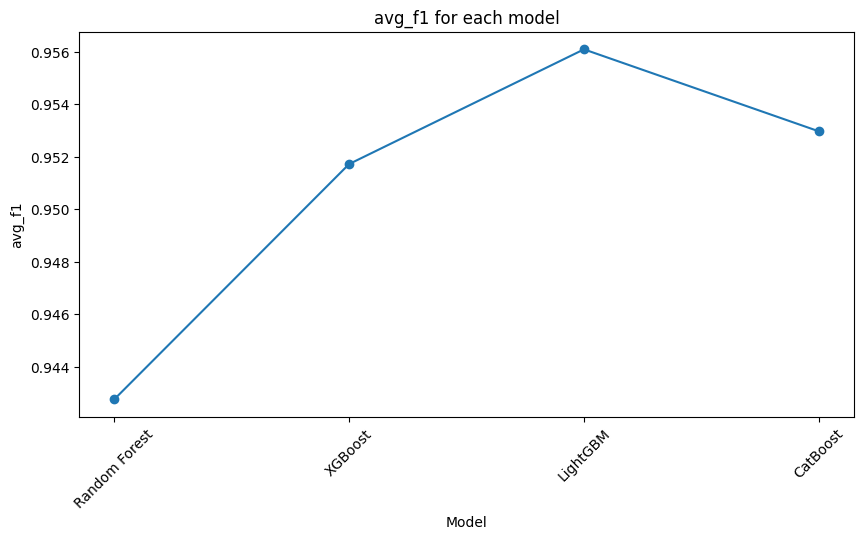

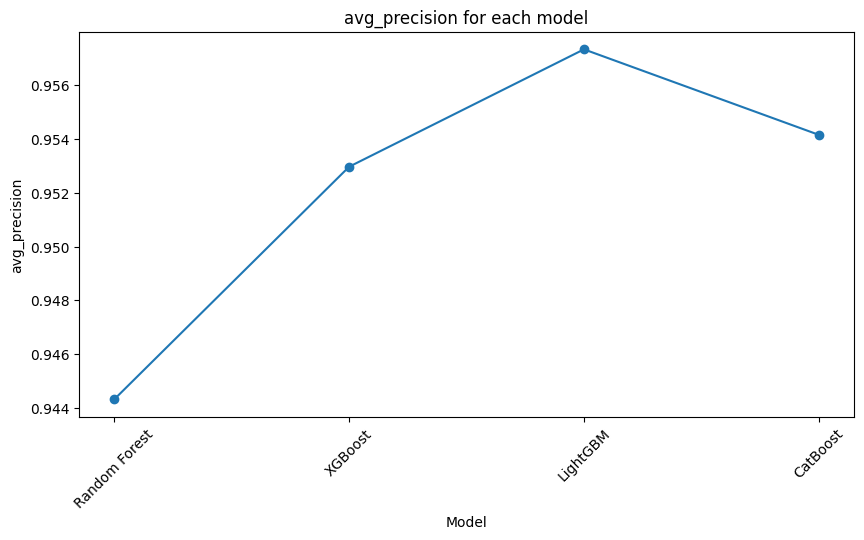

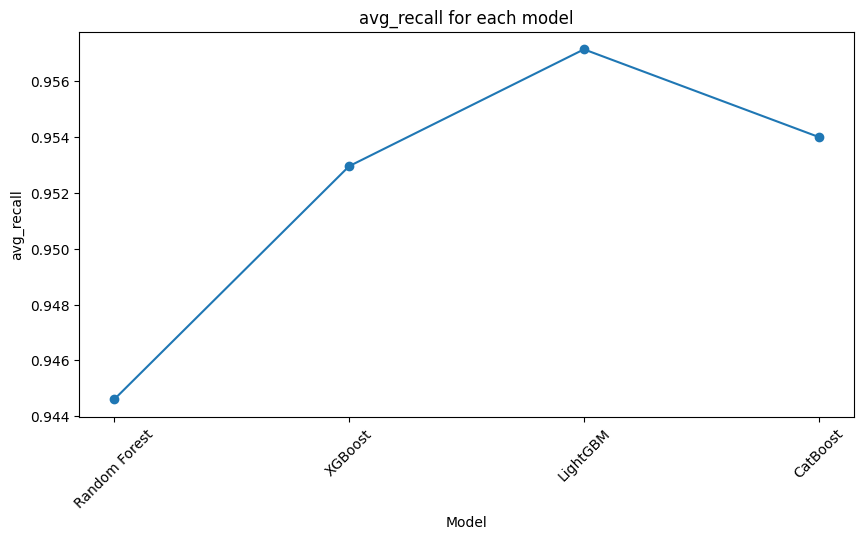

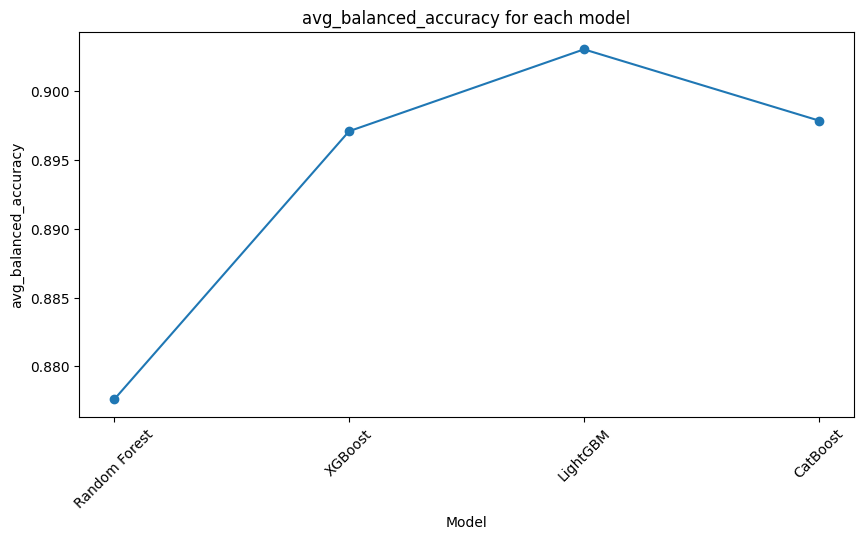

In [53]:
# plot all results in a graph for each metric


def plot_results(results, metric):
    plt.figure(figsize=(10, 5))
    # line plot
    plt.plot(
        list(results.keys()),
        [results[model][metric] for model in results.keys()],
        marker="o",
    )

    plt.title(f"{metric} for each model")
    plt.xlabel("Model")
    plt.ylabel(metric)

    plt.xticks(rotation=45)

    plt.show()


for metric in ["avg_f1", "avg_precision", "avg_recall", "avg_balanced_accuracy"]:

    plot_results(dict_of_results, metric)

# save the best model

In [56]:
# test the model with the test set
test_results = {model: {} for model, _ in models}


def test_model(model, x_test, y_test):
    y_test = LabelEncoder().fit_transform(y_test)

    y_pred = model.predict(x_test)

    f1 = f1_score(y_test, y_pred, average="weighted")
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    avg = np.mean([f1, precision, recall, balanced_accuracy])

    print(f"F1: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Balanced Accuracy: {balanced_accuracy}")
    print(f"Average: {avg}")

    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "balanced_accuracy": balanced_accuracy,
        "avg_metrics": avg,
    }


best_model = max(
    models,
    key=lambda model: dict_of_results[model[0]]["avg_metrics"],
)

print(f"Best model: {best_model[0]}")

model = best_model[1].fit(x_train, y_train)

x_test = test.drop("fetal_health", axis=1)

y_test = test["fetal_health"]

test_results[best_model[0]] = test_model(model, x_test, y_test)


print(f"Test results for best model: {test_results[best_model[0]]}")

Best model: LightGBM
F1: 0.9388596460765297
Precision: 0.9393583724569641
Recall: 0.9389671361502347
Balanced Accuracy: 0.8839572850790134
Average: 0.9252856099406854
Test results for best model: {'f1': 0.9388596460765297, 'precision': 0.9393583724569641, 'recall': 0.9389671361502347, 'balanced_accuracy': 0.8839572850790134, 'avg_metrics': 0.9252856099406854}


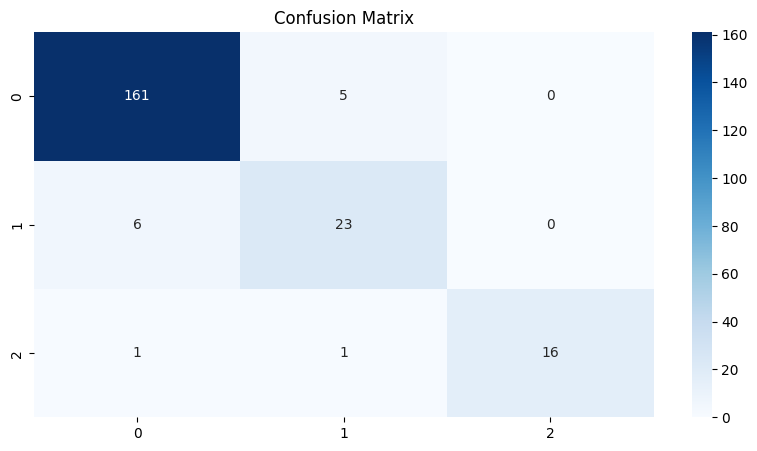

In [57]:
# matrix confusion

import seaborn as sns
from sklearn.metrics import confusion_matrix

y_test = LabelEncoder().fit_transform(y_test)

y_pred = model.predict(x_test)

c = confusion_matrix(y_test, y_pred)

# plot


plt.figure(figsize=(10, 5))

sns.heatmap(c, annot=True, fmt="d", cmap="Blues")

plt.title("Confusion Matrix")

plt.show()

Feature Importance for LightGBM


<Figure size 1000x500 with 0 Axes>

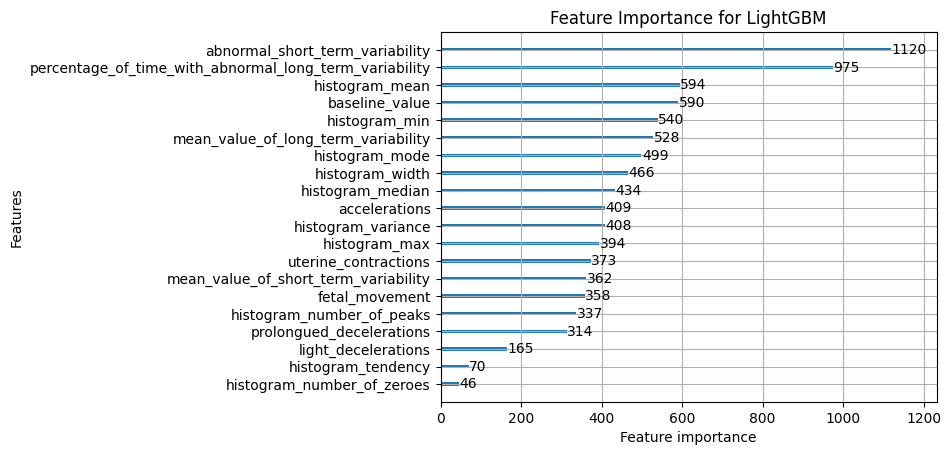

In [64]:
# plot imporante for the best model
print(f"Feature Importance for {best_model[0]}")
plt.figure(figsize=(10, 5))

if best_model[0] == "Random Forest":

    plt.barh(x_train.columns, model.feature_importances_)

    plt.title("Feature Importance for Random Forest")


elif best_model[0] == "XGBoost":

    from xgboost import plot_importance

    plot_importance(model, title="Feature Importance for XGBoost")


elif best_model[0] == "LightGBM":

    from lightgbm import plot_importance

    plot_importance(model, title="Feature Importance for LightGBM")


elif best_model[0] == "CatBoost":

    plt.figure(figsize=(10, 5))

    model.get_feature_importance(prettified=True).plot.barh(
        x="Feature Id", y="Importances"
    )

    plt.title("Feature Importance")



plt.show()